In [1]:
!pip install imgaug                     # for image augmentation

In [2]:
!pip install -U segmentation-models    # ONLY used for dice metric and IOU metric computation, models are made from scratch

     |████████████████████████████████| 51kB 4.3MB/s 


In [3]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from zipfile import ZipFile
from shutil import copyfile, copyfileobj
import gzip
from IPython.display import clear_output
import cv2
import os
from pylab import rcParams
import PIL
from PIL import Image
import scipy
from google.colab import files
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift
import imgaug as ia
import imgaug.augmenters as iaa

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.3.0
Eager mode:  True
GPU is available


In [4]:
import sys
import random
import warnings

import math
import seaborn as sns; sns.set()
from keras.callbacks import Callback
from keras.losses import binary_crossentropy
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
import joblib
import gc
from keras.utils import generic_utils
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [5]:
os.environ['KAGGLE_USERNAME'] = "kanishkapandey" # username from the json file
os.environ['KAGGLE_KEY'] = "76240e9e3c518a7d0844f07ba6617476" # key from the json file

In [6]:
!kaggle datasets download -d andrewmvd/covid19-ct-scans

 99% 1.02G/1.03G [00:48<00:01, 10.4MB/s]
100% 1.03G/1.03G [00:48<00:00, 23.0MB/s]


In [7]:
!kaggle datasets download -d deadskull7/unetpp

404 - Not Found


In [ ]:
#copyfile("/content/drive/My Drive/covid19-ct-scans.zip","/content/covid19-ct-scans.zip")
with ZipFile('unetpp.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('unetpp')

In [8]:
os.listdir()

['.config', 'covid19-ct-scans.zip', 'sample_data']

In [9]:
#copyfile("/content/drive/My Drive/covid19-ct-scans.zip","/content/covid19-ct-scans.zip")
with ZipFile('covid19-ct-scans.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('covid19-ct-scans')

In [10]:
# Read and examine metadata
raw_data = pd.read_csv('/content/covid19-ct-scans/metadata.csv')
raw_data = raw_data.replace('../input/covid19-ct-scans/','/content/covid19-ct-scans/',regex=True)
raw_data.head(5)

ct_scan  ...                            lung_and_infection_mask
0  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
1  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
2  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
3  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
4  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...

[5 rows x 4 columns]

In [11]:
raw_data.shape

(20, 4)

In [12]:
img_size = 512

In [13]:
def clahe_enhancer(test_img, demo):

  test_img = test_img*255
  test_img = np.uint8(test_img)
  test_img_flattened = test_img.flatten()
  
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  clahe_image = clahe.apply(test_img)
  clahe_image_flattened = clahe_image.flatten()

  if demo == 1:

    fig = plt.figure()
    rcParams['figure.figsize'] = 10,10
    
    plt.subplot(2, 2, 1)
    plt.imshow(test_img, cmap='bone')
    plt.title("Original CT-Scan")

    plt.subplot(2, 2, 2)
    plt.hist(test_img_flattened)
    plt.title("Histogram of Original CT-Scan")

    plt.subplot(2, 2, 3)
    plt.imshow(clahe_image, cmap='bone')
    plt.title("CLAHE Enhanced CT-Scan")

    plt.subplot(2, 2, 4)
    plt.hist(clahe_image_flattened)
    plt.title("Histogram of CLAHE Enhanced CT-Scan")

  return(clahe_image)

In [14]:
def cropper(test_img, demo):

  test_img = test_img*255
  test_img = np.uint8(test_img)

  # ret, thresh = cv2.threshold(test_img, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
  # ret, thresh = cv2.threshold(test_img, ret, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 

  contours,hierarchy = cv2.findContours(test_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  areas = [cv2.contourArea(c) for c in contours]

  x = np.argsort(areas)

  max_index = x[x.size - 1]
  cnt1=contours[max_index]
  second_max_index = x[x.size - 2]
  cnt2 = contours[second_max_index]

  # max_index = np.argmax(areas)
  # cnt=contours[max_index]

  x,y,w,h = cv2.boundingRect(cnt1)
  p,q,r,s = cv2.boundingRect(cnt2)

  cropped1 = test_img[y:y+h, x:x+w]
  cropped1 = cv2.resize(cropped1, dsize=(125,250), interpolation=cv2.INTER_AREA)
  cropped2 = test_img[q:q+s, p:p+r]
  cropped2 = cv2.resize(cropped2, dsize=(125,250), interpolation=cv2.INTER_AREA)

  fused = np.concatenate((cropped1, cropped2), axis=1)

  # super_cropped = test_img[y+7:y+h-20, x+25:x+w-25]
  points_lung1 = []
  points_lung2 = []

  points_lung1.append(x); points_lung1.append(y); points_lung1.append(w); points_lung1.append(h)
  points_lung2.append(p); points_lung2.append(q); points_lung2.append(r); points_lung2.append(s)
  
  if demo == 1:

    fig = plt.figure()
    rcParams['figure.figsize'] = 35, 35

    plt.subplot(1, 3, 1)
    plt.imshow(test_img, cmap='bone')
    plt.title("Original CT-Scan")

    plt.subplot(1, 3, 2)
    plt.imshow(thresh, cmap='bone')
    plt.title("Binary Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(fused, cmap='bone')
    plt.title("Cropped CT scan after making bounding rectangle")

    # plt.subplot(1, 4, 4)
    # plt.imshow(super_cropped, cmap='bone')
    # plt.title("Cropped further manually")

    plt.show()

  return(fused, points_lung1, points_lung2)

* Dataset contain 20 files of .nii type, though each file contained multiple channels or silces each as a separate gray scale image.
* Total slices are 3520. These have been sliced out by 20% in the front and by 20% in the last of each file since in general these didn't had any infection masks and some didn't had the lungs, removed as noise.
* Also, images had pixel values from -998 to 1000+. Did min-max scaling.

In [15]:
def read_nii_demo(filepath, data):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    array = array[:,:,round(slices*0.2):round(slices*0.8)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1], 1))

    for img_no in range(0, array.shape[0]):
        # array = Image.resize(array[...,img_no], (img_size,img_size))
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)
        data.append(img)

In [16]:
all_points1 = []
all_points2 = []

In [17]:
def read_nii(filepath, data, string):
    '''
    Reads .nii file and returns pixel array

    '''
    global all_points1
    global all_points2
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    array = array[:,:,round(slices*0.2):round(slices*0.8)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1],1))
    #print(array.shape[2])
    #array = skimage.transform.resize(array, (array.shape[2], img_size, img_size))
    #array = cv2.resize(array, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
    

    if string == "lungs":
      all_points1 = []
      all_points2 = []

    for img_no in range(0, array.shape[0]):
        if string == 'lungs' and np.unique(array[img_no]).size == 1:
          continue
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)

        if string == 'lungs':
          # img = np.uint8(img*255) 
          img[img>0]=1
          img, points1, points2 = cropper(img, demo = 0)
          all_points1.append((points1[0], points1[1], points1[2], points1[3]))
          all_points2.append((points2[0], points2[1], points2[2], points2[3]))
          continue 

        if string == "cts" and img_no < len(all_points1):
          img = clahe_enhancer(img, demo = 0)
          # img, points1, points2 = cropper(img, demo = 0)
          # all_points1.append((points1[0], points1[1], points1[2], points1[3]))
          # all_points2.append((points2[0], points2[1], points2[2], points2[3]))   
          a,b,c,d = all_points1[img_no]
          e,f,g,h = all_points2[img_no]
          img1 = img[b:b+d, a:a+c]
          img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img2 = img[f:f+h, e:e+g]
          img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img = np.concatenate((img1, img2), axis=1)    

        if string == "infections" and img_no < len(all_points1):
          a,b,c,d = all_points1[img_no]
          e,f,g,h = all_points2[img_no]
          img = np.uint8(img*255)
          img1 = img[b:b+d, a:a+c]
          img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img2 = img[f:f+h, e:e+g]
          img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img = np.concatenate((img1, img2), axis=1)


        # img = cv2.resize(img, dsize=(192, 192), interpolation=cv2.INTER_LINEAR)
        # img = img/255
        #  remember to normalize again
        # also resize images and masks for all
        
        data.append(img)

In [18]:
cts = []
lungs = []
infections = []

In [19]:
for i in range(0, 20):
    read_nii(raw_data.loc[i,'lung_mask'], lungs, 'lungs')
    read_nii(raw_data.loc[i,'ct_scan'], cts, 'cts') 
    read_nii(raw_data.loc[i,'infection_mask'], infections, 'infections')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


In [20]:
print(len(cts), len(infections))

2112 2112


(250, 250) (250, 250)


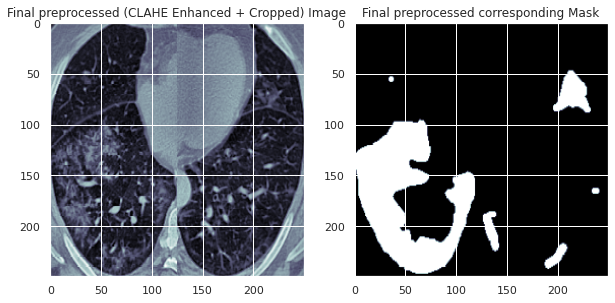

In [21]:
x = 60

rcParams['figure.figsize'] = 10,10

plt.subplot(1, 2, 1)
plt.imshow(cts[x], cmap='bone')
plt.title("Final preprocessed (CLAHE Enhanced + Cropped) Image")

plt.subplot(1, 2, 2)
plt.imshow(infections[x], cmap='bone')
plt.title("Final preprocessed corresponding Mask")

print(cts[x].shape, infections[x].shape)

In [22]:
no_masks = []
for i in range(0, len(infections)):
  if np.unique(infections[i]).size == 1:
    no_masks.append(i)
print("Number of complete black masks :" , len(no_masks))

for index in sorted(no_masks, reverse = True):  
    del infections[index]  
    del cts[index]

Number of complete black masks : 497


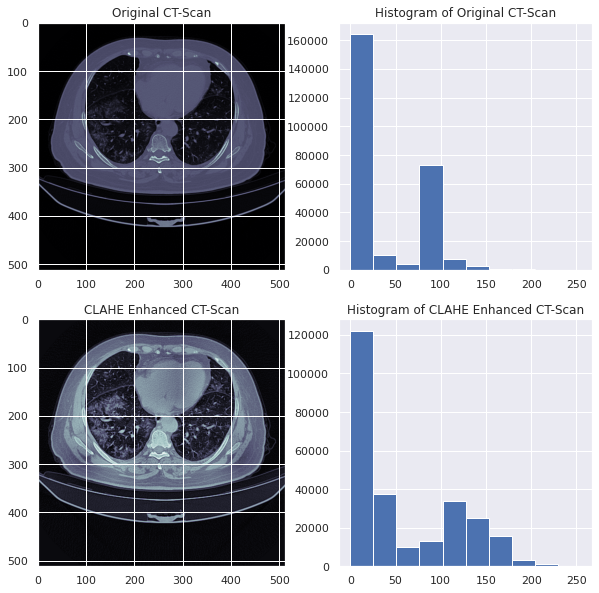

In [23]:
test_file = []
read_nii_demo(raw_data.loc[0,'ct_scan'], test_file)
test_file = np.array(test_file)
rcParams['figure.figsize'] = 10, 10
clahe_image = clahe_enhancer(test_file[60], demo = 1)

In [24]:
# fig = plt.figure()
# rcParams['figure.figsize'] = 35, 35

# cropped_image, points1, points2 = cropper(test_file[120], demo = 1)
# #print(ret)
# print(points1, points2)

In [25]:
# test_mask = []
# read_nii_demo(raw_data.loc[0,'infection_mask'], test_mask)
# test_mask = np.array(test_mask)
# test_mask = np.uint8(test_mask*255)
# rcParams['figure.figsize'] = 10,10
# plt.imshow(test_mask[120][20:155, 4:217], cmap = 'bone')
# test_mask[120][20:155, 4:217].shape

In [26]:
print(len(cts) , len(infections))

1615 1615


In [27]:
dim1=[]
dim2=[]
for i in range(0, len(cts)):
  dim1.append(cts[i].shape[0])
  dim2.append(cts[i].shape[1])
dim1 = np.array(dim1)
dim2 = np.array(dim2)

print("An idea about the new net dimension to which all must be resized to (some will increase and some decrease) --->", np.median(dim1),'x', np.median(dim2))

An idea about the new net dimension to which all must be resized to (some will increase and some decrease) ---> 250.0 x 250.0


In [28]:
# 32*11 = 352

In [29]:
new_dim = 224

In [30]:
for i in range(0,len(cts)):
  cts[i] = cv2.resize(cts[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  # cts[i] = cts[i]/255
  infections[i] = cv2.resize(infections[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  # infections[i] = infections[i]/255

In [31]:
# for i in range(0, len(cts)):
#   cts[i] = cv2.cvtColor(cts[i], cv2.COLOR_GRAY2RGB)
# for i in range(0, len(infections)):
#   infections[i] = cv2.cvtColor(infections[i], cv2.COLOR_GRAY2RGB)

In [32]:
cts = np.array(cts)
infections = np.array(infections)

In [33]:
# cts = cts.reshape( len(cts), new_dim, new_dim)
# infections = infections.reshape( len(infections), new_dim, new_dim)

In [34]:
cts = np.uint8(cts)
infections = np.uint8(infections)

In [35]:
# No Augmentation added this time

* Data augmentation pipeline

In [36]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.2), # vertically flip 20% of all images
    sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-40, 40), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            # mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ))
], random_order=True)

In [37]:
no_of_aug_imgs = 130
random_indices = np.random.randint(0, cts.shape[0], size=no_of_aug_imgs)
sample_cts = cts[random_indices]
sample_inf = infections[random_indices]

In [38]:
# sample_cts = np.floor(sample_cts)
# sample_inf = np.floor(sample_inf)
# sample_cts = np.uint64(sample_cts)
# sample_inf = np.uint64(sample_inf)

In [39]:
cts_aug, infections_aug = seq(images=sample_cts, 
                              segmentation_maps=sample_inf)

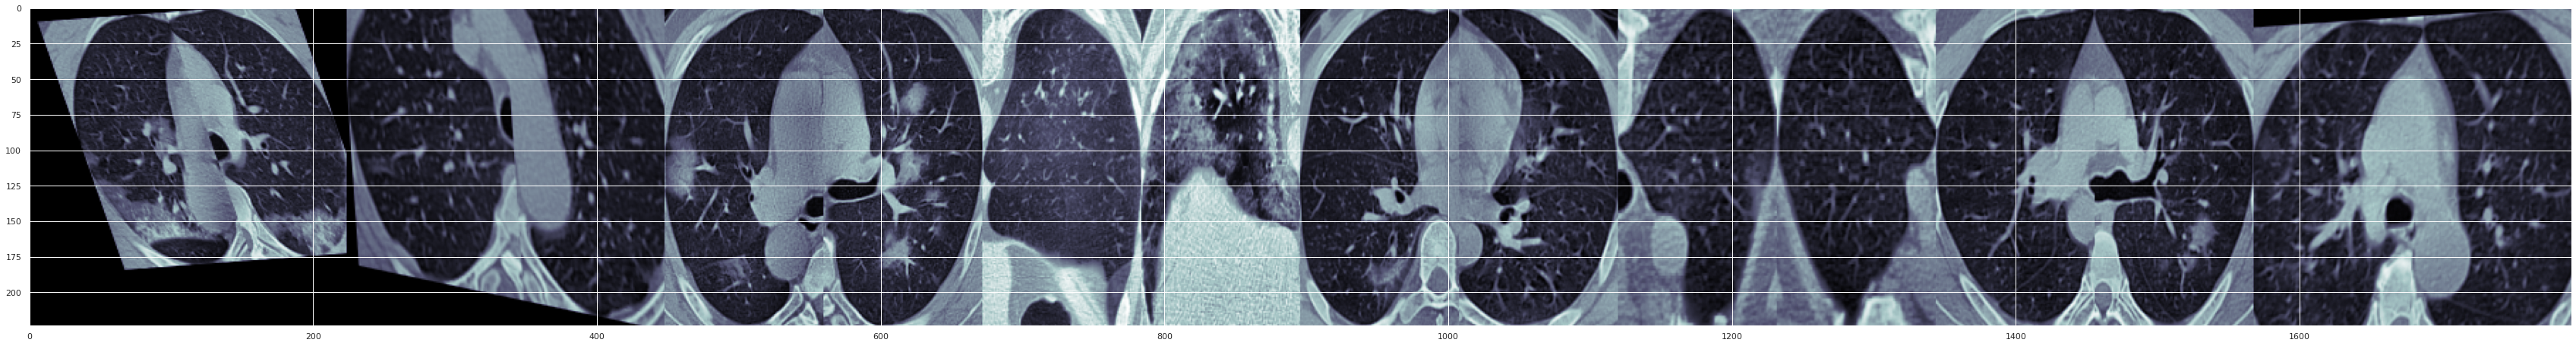

In [40]:
rcParams['figure.figsize'] = 60,60
rand = np.random.randint(0, no_of_aug_imgs, size=8)

cells1 = cts_aug[rand]
grid_image1 = np.hstack(cells1)
plt.imshow(grid_image1, cmap = 'bone')

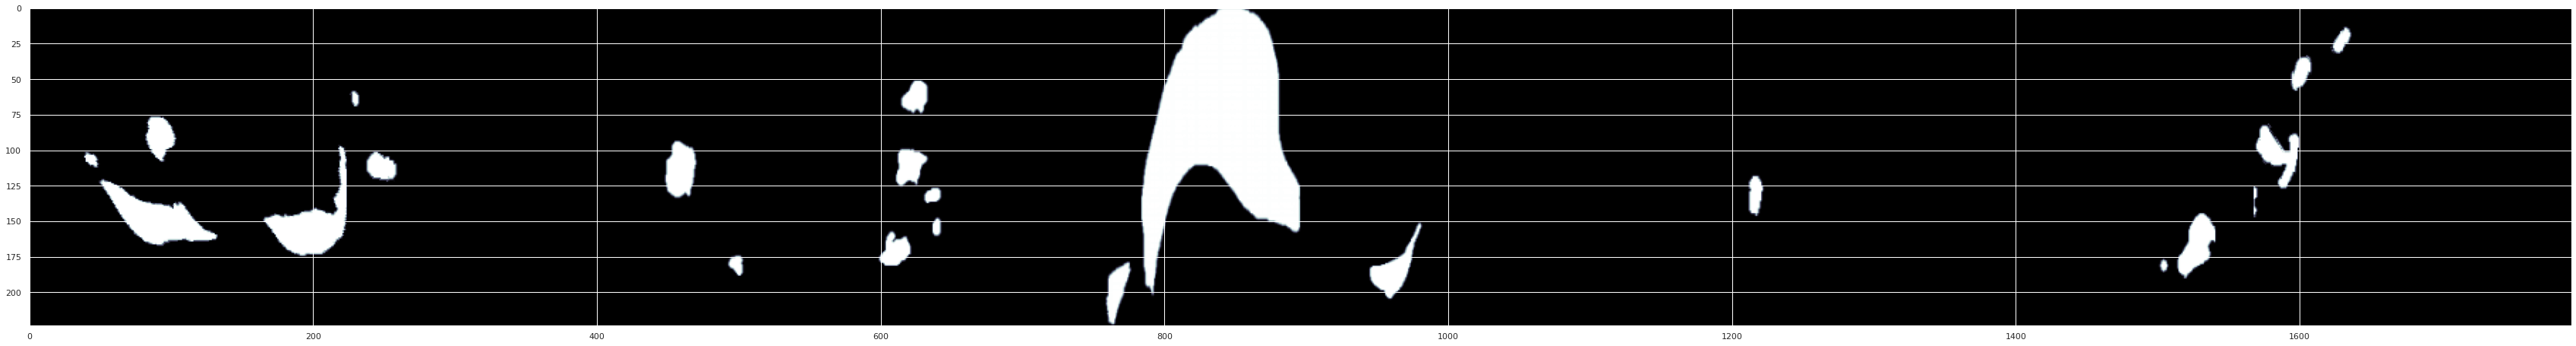

In [41]:
cells2 = infections_aug[rand]
grid_image2 = np.hstack(cells2)
plt.imshow(grid_image2, cmap = 'bone')

In [42]:
print(cts_aug.shape, infections_aug.shape)

(130, 224, 224) (130, 224, 224)


In [ ]:
# cts = np.concatenate((cts, cts_aug), axis=0)
# infections = np.concatenate((infections, infections_aug), axis = 0)
# np.random.shuffle(cts)
# np.random.shuffle(infections)
# print(cts.shape, infections.shape)

In [43]:
cts_aug = cts_aug/255
infections_aug = infections_aug/255
cts_aug = cts_aug.reshape(len(cts_aug), new_dim, new_dim, 1)
infections_aug = infections_aug.reshape(len(infections_aug), new_dim, new_dim, 1)

* Normalizing images and masks from 0 to 1

In [44]:
joblib.dump(cts, 'cts_cropped_lungs_224.pkl')

['cts_cropped_lungs_224.pkl']

In [47]:
files.download('cts_cropped_lungs_224.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
joblib.dump(infections, 'infections_cropped_lungs_224.pkl')

['infections_cropped_lungs_224.pkl']

In [49]:
files.download('infections_cropped_lungs_224.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
# temp = joblib.load('infections_cropped_lungs_224.pkl')

In [51]:
cts = cts/255
infections = infections/255

In [52]:
cts = cts.reshape(len(cts), new_dim, new_dim, 1)
infections = infections.reshape(len(infections), new_dim, new_dim, 1)

In [53]:
# cts_new = []
# # lungs_infections_new = []
# infections_new = []

In [54]:
# for i in range(0, 2112):
#   cts_new.append(np.array(cts[i]))
#   # lungs_infections_new.append(np.array(lungs_infections[i]))
#   infections_new.append(np.array(infections[i]))

In [55]:
# cts_new = np.array(cts_new)
# # lungs_infections_new = np.array(lungs_infections_new)
# infections_new = np.array(infections_new)

In [56]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(10,30))

    plt.subplot(1,2,1)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image')

    # plt.subplot(1,2,2)
    # plt.imshow(array_list[0], cmap='bone')
    # plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    # plt.title('Lung Mask')

    plt.subplot(1,2,2)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.imshow(array_list[1].reshape(new_dim, new_dim), alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')

    # plt.subplot(1,2,2)
    # plt.imshow(array_list[0].reshape(img_size,img_size), cmap='bone')
    # plt.imshow(array_list[1].reshape(img_size, img_size), alpha=0.5, cmap=color_map)
    # plt.title('Lung and Infection Mask')

#     plt.subplot(1,4,4)
#     plt.imshow(array_list[0], cmap='bone')
#     plt.imshow(array_list[3], alpha=0.5, cmap=color_map)
#     plt.title('Lung and Infection Mask')

    plt.show()

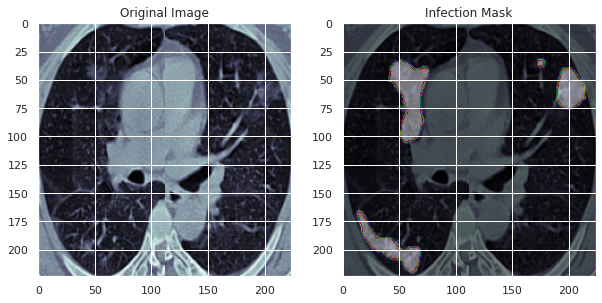

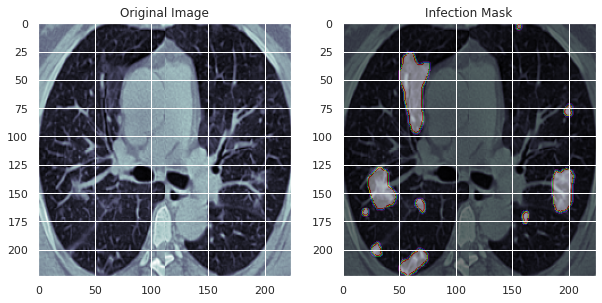

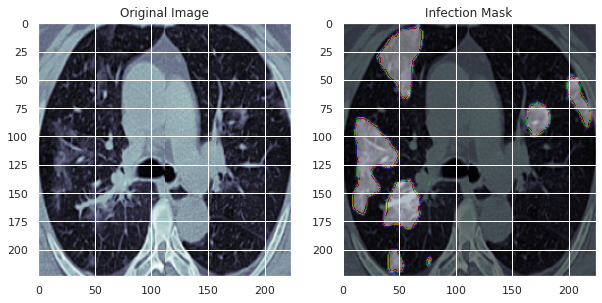

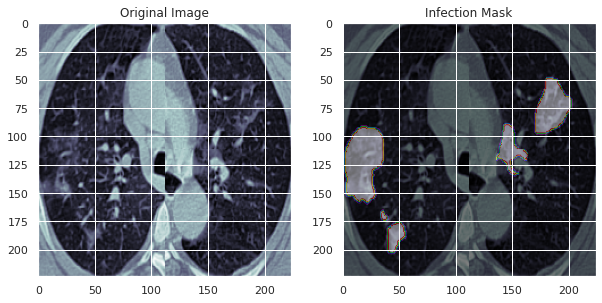

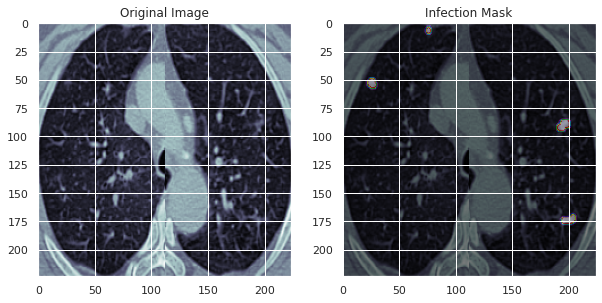

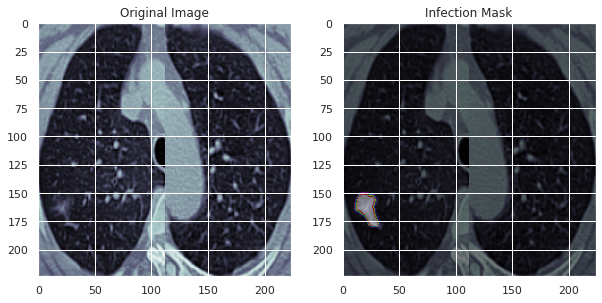

In [57]:
for index in [100,110,120,130,140,150]:
    plot_sample([cts[index], infections[index]])

In [58]:
x_train, x_valid, y_train, y_valid = train_test_split(cts, infections, test_size=0.3, random_state=42)

In [59]:
print(x_train.shape, x_valid.shape)

(1130, 224, 224, 1) (485, 224, 224, 1)


In [60]:
# x_train = np.concatenate((x_train, cts_aug), axis=0)
# y_train = np.concatenate((y_train, infections_aug), axis = 0)
# print(x_train.shape, y_train.shape)

* Loss functions and metrics

In [61]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = 0.5*binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

* All the hyperparameters are put in place after repeating trial and error for a fixed number of epochs.

In [62]:
dropout_rate = 0.4
activation = "elu"
def conv_block(input_tensor, num_of_channels, kernel_size=3):
    x = Conv2D(num_of_channels, (kernel_size, kernel_size), activation=activation, kernel_initializer = 'he_normal', padding='same' )(input_tensor)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = Conv2D(num_of_channels, (kernel_size, kernel_size), activation=activation, kernel_initializer = 'he_normal', padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    return x

In [63]:
#Build and train our neural network
inputs = Input((new_dim, new_dim, 1))

c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.2) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.2) (c2)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

up1_2 = Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c2)
conv1_2 = concatenate([up1_2,c1],axis=3)
conv1_2 = conv_block(conv1_2, num_of_channels=32)

c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

up2_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
conv2_2 = concatenate([up2_2, c2], axis=3)
conv2_2 = conv_block(conv2_2, num_of_channels=64)

up1_3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, conv1_2], axis=3)
conv1_3 = conv_block(conv1_3, num_of_channels=32)

c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

up3_2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
conv3_2 = concatenate([up3_2, c3], axis=3)
conv3_2 = conv_block(conv3_2, num_of_channels=128)

up2_3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2], axis=3)
conv2_3 = conv_block(conv2_3, num_of_channels=64)

up1_4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, conv1_2, conv1_3], axis=3)
conv1_4 = conv_block(conv1_4, num_of_channels=32)

# c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
# c5 = Dropout(0.5) (c5)
# c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

# up4_2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
# conv4_2 = concatenate([up4_2, c4],  axis=3)
# conv4_2 = conv_block(conv4_2,  num_of_channels=256)

# up3_3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4_2)
# conv3_3 = concatenate([up3_3, c3, conv3_2],  axis=3)
# conv3_3 = conv_block(conv3_3, num_of_channels=128)

# up2_4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3_3)
# conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], axis=3)
# conv2_4 = conv_block(conv2_4, num_of_channels=64)

# up1_5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_4)
# conv1_5 = concatenate([up1_5, c1, conv1_2, conv1_3, conv1_4],  axis=3)
# conv1_5 = conv_block(conv1_5, num_of_channels=32)

nestnet_output = Conv2D(1, (1, 1), activation ='sigmoid',
                        kernel_initializer= 'he_normal', padding='same')(conv1_4)
    
unetpp = Model(inputs=[inputs], outputs=[nestnet_output])
unetpp.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 224, 224, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 9248        dropout[0][0]                    
_______________________________________________________________________________________

* Some callbacks (model checkpointing with least validation loss, highest validation dice coefficient, learning rate reduction after some patience number of epochs)
* Also experimented with exponential decaying learning rate but found ReduceLROnPlateau a bit effective in this case.

In [64]:
# import math
# def step_decay(epoch):
#     initial_lrate = 0.0008
#     drop = 0.8
#     epochs_drop = 10
#     lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
#     print('New learning rate', lrate)
#     return lrate

# lrate = LearningRateScheduler(step_decay)

In [65]:
def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 0.5*weighted_bce_loss(y_true, y_pred, weight) + 0.5*dice_loss(y_true, y_pred)
    return loss

In [66]:
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=1):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        print('\nEpoch %05d: CosineAnnealingScheduler setting learning ''rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [67]:
cosine_annealer = CosineAnnealingScheduler(T_max=7, eta_max=0.0005, eta_min=0.0001)

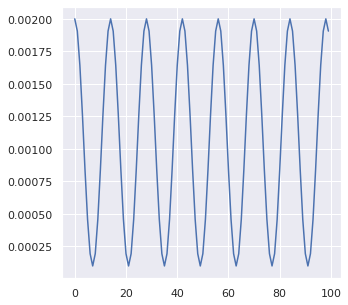

In [68]:
rcParams['figure.figsize'] = 5,5
T_max=7
eta_max=0.002
eta_min = 0.0001
lr=[]
for epoch in range(100):    
    lr.append(eta_min + (eta_max - eta_min) * (1 + math.cos(math.pi * epoch / T_max)) / 2)
lr = np.array(lr)
plt.plot(lr)

In [69]:
batch_size = 32
epochs = 80
#lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=7, verbose=1)
filepath_dice_coeff="unet_covid_weights_dice_coeff.hdf5"
filepath_loss = "unet_covid_weights_val_loss.hdf5"
checkpoint_dice = ModelCheckpoint(filepath_dice_coeff, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')
checkpoint_loss = ModelCheckpoint(filepath_loss, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [70]:
unetpp.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice_coeff])

In [71]:
results = unetpp.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_valid, y_valid),
                    callbacks = [checkpoint_dice, checkpoint_loss])

Epoch 1/80
36/36 [==============================] - ETA: 0s - loss: 0.7984 - dice_coeff: 0.1590
Epoch 00001: val_dice_coeff improved from -inf to 0.06091, saving model to unet_covid_weights_dice_coeff.hdf5

Epoch 00001: val_loss improved from inf to 0.67194, saving model to unet_covid_weights_val_loss.hdf5
36/36 [==============================] - 22s 619ms/step - loss: 0.7984 - dice_coeff: 0.1590 - val_loss: 0.6719 - val_dice_coeff: 0.0609
Epoch 2/80
36/36 [==============================] - ETA: 0s - loss: 0.6633 - dice_coeff: 0.2411
Epoch 00002: val_dice_coeff improved from 0.06091 to 0.12420, saving model to unet_covid_weights_dice_coeff.hdf5

Epoch 00002: val_loss did not improve from 0.67194
36/36 [==============================] - 20s 561ms/step - loss: 0.6633 - dice_coeff: 0.2411 - val_loss: 1.5524 - val_dice_coeff: 0.1242
Epoch 3/80
36/36 [==============================] - ETA: 0s - loss: 0.5860 - dice_coeff: 0.2895
Epoch 00003: val_dice_coeff improved from 0.12420 to 0.16156, s

In [72]:
gc.collect()

1542

In [73]:
unetpp.load_weights('unet_covid_weights_dice_coeff.hdf5')

In [74]:
score = unetpp.evaluate(x_valid, y_valid, batch_size=32)
print("test loss, test dice coefficient:", score)

16/16 [==============================] - 2s 124ms/step - loss: 0.1128 - dice_coeff: 0.8644
test loss, test dice coefficient: [0.11279750615358353, 0.8643916249275208]


* Model saved in json format and its weight in .hdf5 format at local

In [75]:
unetpp.save_weights('unetpp_0.87.h5')

In [76]:
files.download('unetpp_0.87.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [77]:
model_json = unetpp.to_json()
with open("unetpp_0.87.json","w") as json_file:
     json_file.write(model_json)

files.download("unetpp_0.87.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* Saved model results --> validation loss: 0.1504 and validation dice coefficient: 0.8780

* Though highest validation dice coefficient was 0.8789 but didn't saved it 
because of its high val loss of 0.1547

* I have specifically saved the least loss model rather than highest dice coefficient because, loss is generally a better predictor for overfitting, as you can see the validation dice coefficient still increased in the 79 th epoch when there was overfitting but loss was last saved on 51 st epoch, thus refrained more from overfitting.

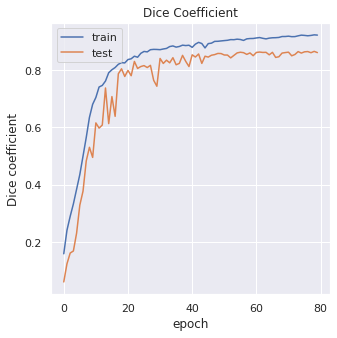

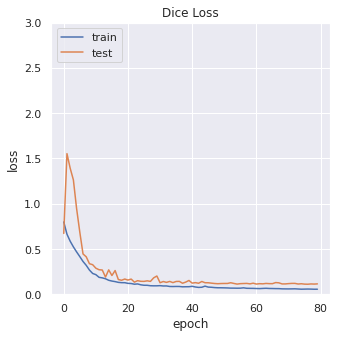

In [78]:
rcParams['figure.figsize'] = 5, 5
plt.plot(results.history['dice_coeff'])
plt.plot(results.history['val_dice_coeff'])
plt.title('Dice Coefficient')
plt.ylabel('Dice coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.ylim(0, 3)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Dice Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

* Some actual vs predicted samples to check the performance of the model visually. Notice, how overlapping they are with each other, thus justifying the high dice coefficient.

In [79]:
plt.rcParams["axes.grid"] = False

In [80]:
def compare_actual_and_predicted(image_no):
    temp = unetpp.predict(cts[image_no].reshape(1,new_dim, new_dim, 1))

    fig = plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    plt.imshow(cts[image_no].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image (CT)')

    plt.subplot(1,3,2)
    plt.imshow(infections[image_no].reshape(new_dim,new_dim), cmap='bone')
    plt.title('Actual mask')

    plt.subplot(1,3,3)
    plt.imshow(temp.reshape(new_dim,new_dim), cmap='bone')
    plt.title('Predicted mask')

    plt.show()
    
# plt.imshow(temp.reshape(img_size, img_size), cmap = 'bone')
# plt.imshow(infections_scaled[120].reshape(img_size, img_size), cmap ='summer')

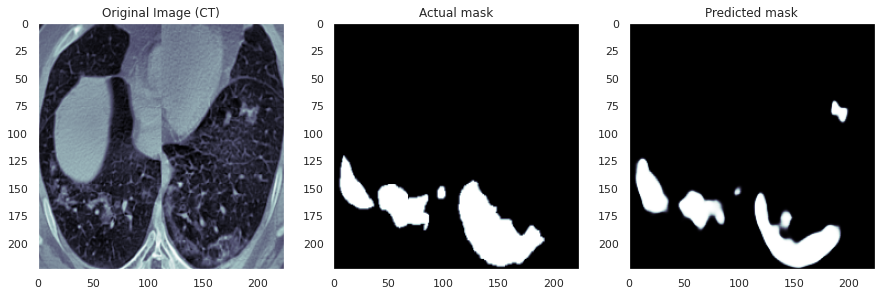

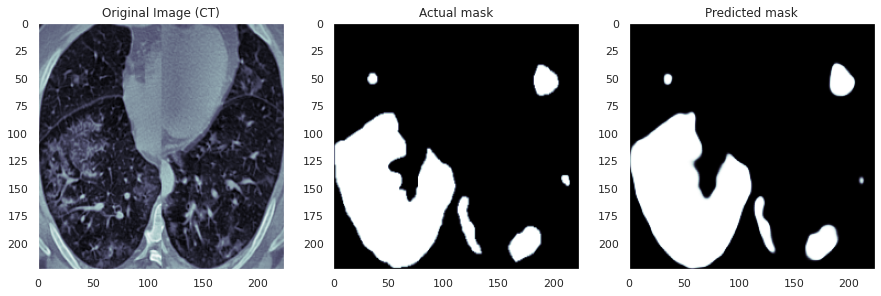

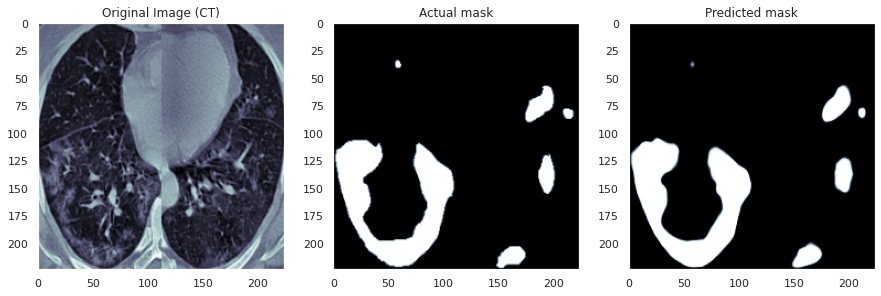

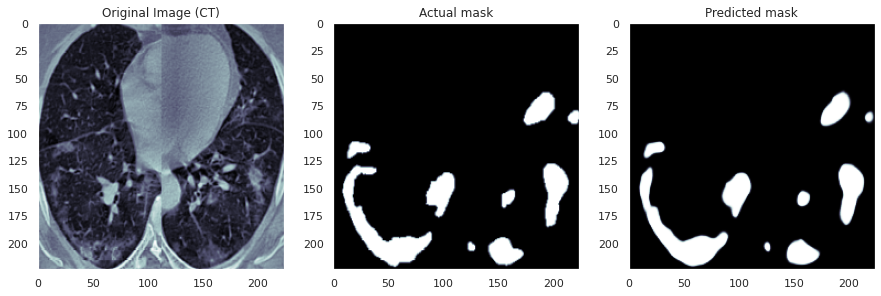

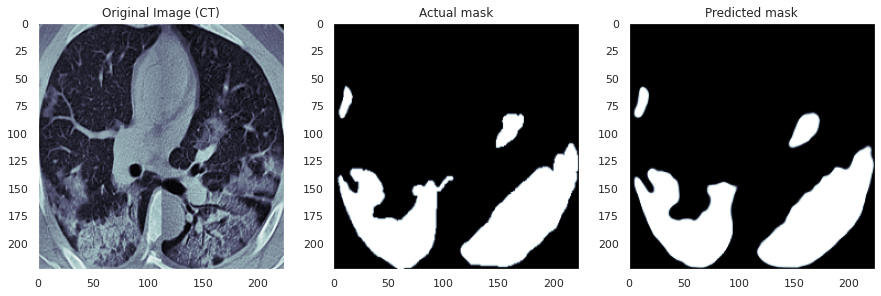

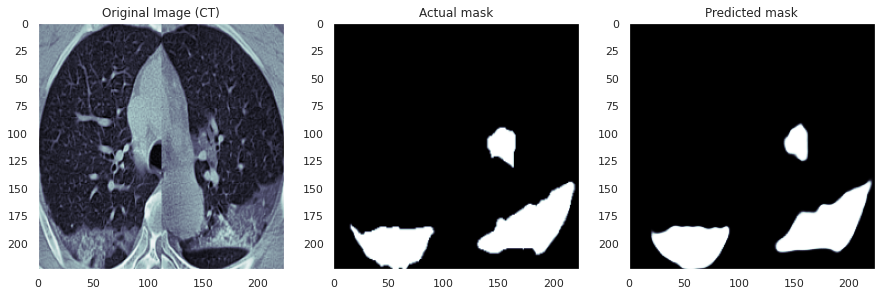

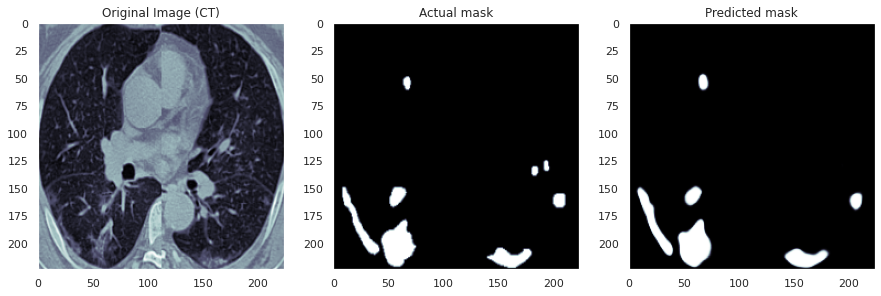

In [81]:
for i in [30,40,50,55, 355, 380, 90]:
    compare_actual_and_predicted(i)

In [82]:
gc.collect()

52515

# Some Significant Post-Processing

In [83]:
the_range = np.arange(0.10,0.80, 0.05)

In [84]:
dices=[]
ious=[]

for t in the_range:
  iou = sm.metrics.IOUScore(threshold=t)
  dice = sm.metrics.FScore(threshold=t)
  unetpp.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice, iou])
  score = unetpp.evaluate(x_valid, y_valid, batch_size=32)
  dices.append(score[1])
  ious.append(score[2])

16/16 [==============================] - 2s 125ms/step - loss: 0.1128 - f1-score: 0.8652 - iou_score: 0.7627


In [85]:
print('DICES:',dices)
print("IOUS:",ious)
print("Best Threshold:", the_range[np.argmax(dices)])
print("Best dice score:", dices[np.argmax(dices)])
print("Best iou score:", ious[np.argmax(ious)])

DICES: [0.8685691356658936, 0.8693760633468628, 0.8696706891059875, 0.8697322010993958, 0.8696686029434204, 0.8694689273834229, 0.8692446947097778, 0.8689233064651489, 0.86857008934021, 0.868126392364502, 0.8676372170448303, 0.8670814633369446, 0.8662578463554382, 0.8652390837669373]
IOUS: [0.7678561210632324, 0.7691189050674438, 0.7695840001106262, 0.7696800827980042, 0.7695813179016113, 0.7692704200744629, 0.7689220905303955, 0.7684211134910583, 0.7678694725036621, 0.7671770453453064, 0.76641446352005, 0.7655516266822815, 0.7642722129821777, 0.762688159942627]
Best Threshold: 0.25000000000000006
Best dice score: 0.8697322010993958
Best iou score: 0.7696800827980042


Best Threshold: 0.25000000000000006


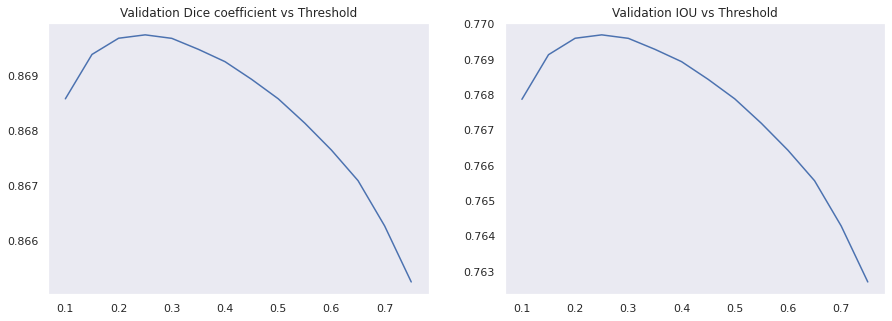

In [86]:
print("Best Threshold:", the_range[np.argmax(dices)])
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(the_range, dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(the_range, ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [87]:
the_new_range = np.arange(0.40,0.50, 0.001)

In [88]:
new_dices=[]
new_ious=[]

for t in the_new_range:
  iou = sm.metrics.IOUScore(threshold=t)
  dice = sm.metrics.FScore(threshold=t)
  unetpp.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice, iou])
  score = unetpp.evaluate(x_valid, y_valid, batch_size=32)
  new_dices.append(score[1])
  new_ious.append(score[2])

16/16 [==============================] - 2s 125ms/step - loss: 0.1128 - f1-score: 0.8686 - iou_score: 0.7679


In [89]:
print("We just checked for",len(the_new_range), "steps between 0.40 and 0.50")

We just checked for 100 steps between 0.40 and 0.50


In [90]:
print('NEW DICES:',new_dices)
print("NEW IOUS:",new_ious)
print("New Best Threshold:", the_new_range[np.argmax(new_dices)])
print("Best new dice score:", new_dices[np.argmax(new_dices)])
print("Best new iou score:", new_ious[np.argmax(new_ious)])

NEW DICES: [0.8692446947097778, 0.8692337274551392, 0.8692287802696228, 0.8692315220832825, 0.869225025177002, 0.8692298531532288, 0.8692283034324646, 0.8692162036895752, 0.869208812713623, 0.8691994547843933, 0.8691850304603577, 0.8691729307174683, 0.8691694736480713, 0.8691590428352356, 0.8691509366035461, 0.8691407442092896, 0.869137704372406, 0.8691307306289673, 0.8691199421882629, 0.8691081404685974, 0.8691068887710571, 0.86910080909729, 0.8690934777259827, 0.8690878748893738, 0.8690820932388306, 0.8690775632858276, 0.8690685033798218, 0.8690590858459473, 0.8690513968467712, 0.8690385818481445, 0.8690325021743774, 0.8690314292907715, 0.8690219521522522, 0.8690142631530762, 0.8690040111541748, 0.8690038323402405, 0.8690012693405151, 0.8689940571784973, 0.8689965009689331, 0.8689888119697571, 0.8689832091331482, 0.8689783215522766, 0.8689743280410767, 0.8689647912979126, 0.8689575791358948, 0.8689520359039307, 0.8689418435096741, 0.8689380288124084, 0.868928849697113, 0.868930399417

Best Threshold: 0.4


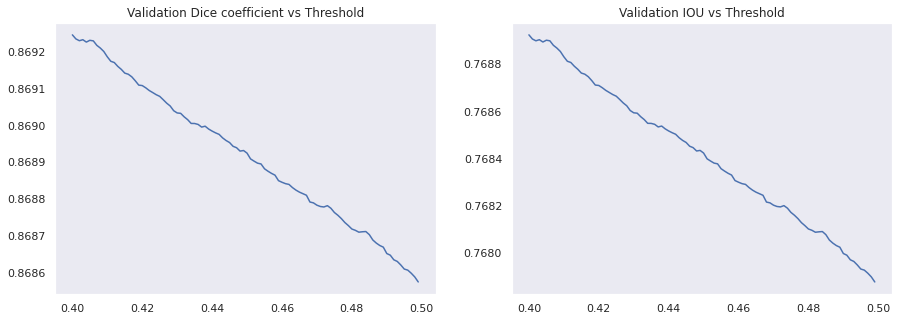

In [91]:
print("Best Threshold:", the_new_range[np.argmax(new_dices)])
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(the_new_range, new_dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(the_new_range, new_ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [92]:
the_prec_rec_range = np.arange(0,1, 0.05)

In [93]:
precisions=[]
recalls=[]

for t in the_prec_rec_range:
  precision = sm.metrics.Precision(threshold=t)
  recall = sm.metrics.Recall(threshold=t)
  unetpp.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[precision, recall])
  score = unetpp.evaluate(x_valid, y_valid, batch_size=32)
  precisions.append(score[1])
  recalls.append(score[2])

16/16 [==============================] - 2s 124ms/step - loss: 0.1128 - precision: 0.9200 - recall: 0.7963


In [94]:
print('PRECISIONS:',precisions)
print("RRECALLS:",recalls)
print("Best Threshold for Precision:", the_prec_rec_range[np.argmax(precisions)])
print("Best Threshold for Recall:", the_prec_rec_range[np.argmax(recalls)])
print("Best precision score:", precisions[np.argmax(precisions)])
print("Best recall score:", recalls[np.argmax(recalls)])

PRECISIONS: [0.06793901324272156, 0.8336672782897949, 0.8471288681030273, 0.8549391627311707, 0.8605892658233643, 0.8651484847068787, 0.869027853012085, 0.8724473714828491, 0.8756591081619263, 0.8786469101905823, 0.8815491199493408, 0.8844393491744995, 0.8873172998428345, 0.8903944492340088, 0.8935046792030334, 0.896820604801178, 0.9006056189537048, 0.9050000309944153, 0.9108036160469055, 0.9199891090393066]
RRECALLS: [1.0, 0.9020116329193115, 0.8913087248802185, 0.8844936490058899, 0.8791354298591614, 0.874552309513092, 0.8704976439476013, 0.8666996955871582, 0.8631150722503662, 0.8596031069755554, 0.8561605215072632, 0.8525952696800232, 0.8490057587623596, 0.8451563119888306, 0.840823233127594, 0.8360092043876648, 0.8303139805793762, 0.8231943845748901, 0.8134475946426392, 0.7963202595710754]
Best Threshold for Precision: 0.9500000000000001
Best Threshold for Recall: 0.0
Best precision score: 0.9199891090393066
Best recall score: 1.0


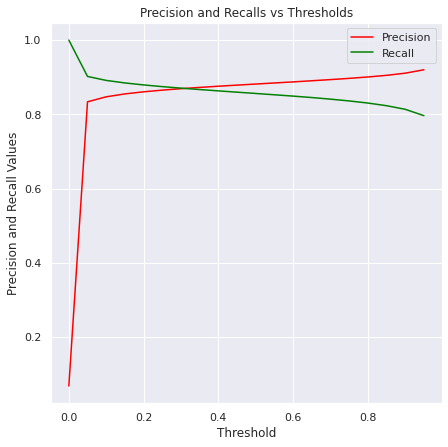

In [95]:
rcParams['figure.figsize'] = 7,7
plt.rcParams["axes.grid"] = True
plt.title("Precision and Recalls vs Thresholds")
plt.xlabel('Threshold')
plt.ylabel('Precision and Recall Values')
plt.plot(the_prec_rec_range,precisions, color='red')
plt.plot(the_prec_rec_range, recalls, color='green')
plt.legend(['Precision', 'Recall'])